Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import datetime
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

Data Importing and Cleaning

In [2]:
df_timestamp = pd.read_csv('/Users/asifbala/Springboard-Data-Science/data_science_take_home_challenge_relax_inc/takehome_user_engagement.csv',encoding='latin-1')
df_users = pd.read_csv('/Users/asifbala/Springboard-Data-Science/data_science_take_home_challenge_relax_inc/takehome_users.csv', encoding='latin-1')

Create Binary Target Variable 'Adopted' to check for user adoption

In [3]:
date_list = list(df_timestamp['time_stamp'])

date = pd.to_datetime(date_list)

df_timestamp['time_stamp'] = list(date)

df_timestamp['time_stamp'] = df_timestamp['time_stamp'].dt.floor('d').astype(np.int64)

df_timestamp = df_timestamp.sort_values(['user_id', 'time_stamp']).drop_duplicates()

rolling_timestamp = df_timestamp.groupby('user_id')['time_stamp'].rolling(window=3)

days_rolling_timestamp = pd.to_timedelta((rolling_timestamp.max()- rolling_timestamp.min())).dt.days

print(days_rolling_timestamp.head())

adopted_users = days_rolling_timestamp[days_rolling_timestamp < 8].index.get_level_values('user_id').tolist()

adopted_users_set = set(adopted_users)

adopted_users_list = list(adopted_users_set)

new_df = pd.DataFrame({'range': range(len(adopted_users_list))}, index = adopted_users_list)

print(new_df.index)

df_users['adopted'] = np.where(df_users['object_id'].isin(new_df.index),1,0)

print(df_users['adopted'].head())

print(df_users.head())

user_id   
1        0     NaN
2        1     NaN
         2     NaN
         3    24.0
         4    26.0
Name: time_stamp, dtype: float64
Int64Index([8192,    2, 8196, 8201,   10,   20, 8214, 8217, 8220, 8221,
            ...
            8130, 8134, 8137, 8149, 8156, 8159, 8161, 8166, 8169, 8191],
           dtype='int64', length=1656)
0    0
1    1
2    0
3    0
4    0
Name: adopted, dtype: int64
   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com 

Check for Class Imbalance

In [4]:
class_counts = df_users['adopted'].value_counts()

print(class_counts)

0    10344
1     1656
Name: adopted, dtype: int64


Fix Class Imbalance

1    1656
0    1656
Name: adopted, dtype: int64


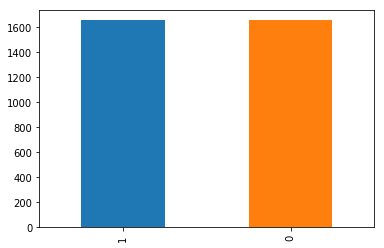

    object_id        creation_time            name  \
1           2  2013-11-15 03:45:04   Poole Matthew   
9          10  2013-01-16 22:08:03    Santos Carla   
19         20  2014-03-06 11:46:38   Helms Mikayla   
32         33  2014-03-11 06:29:09     Araujo José   
41         42  2012-11-11 19:05:07  Pinto Giovanna   

                            email creation_source  last_session_creation_time  \
1          MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
9   CarlaFerreiraSantos@gustr.com      ORG_INVITE                1.401833e+09   
19             lqyvjilf@uhzdq.com          SIGNUP                1.401364e+09   
32     JoseMartinsAraujo@cuvox.de    GUEST_INVITE                1.401518e+09   
41    GiovannaCunhaPinto@cuvox.de          SIGNUP                1.401045e+09   

    opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
1                          0                           0       1   
9                          1                        

In [5]:
#Find Number of samples which are adopted
no_adopted = len(df_users[df_users['adopted'] == 1])

#Get indices of non adopted samples
non_adopted_indices = df_users[df_users.adopted == 0].index

#Random sample non adopted indices
random_indices = np.random.choice(non_adopted_indices,no_adopted, replace=False)

#Find the indices of adopted samples
adopted_indices = df_users[df_users.adopted == 1].index

#Concat adopted indices with sample non-adopted ones
under_sample_indices = np.concatenate([adopted_indices,random_indices])

#Get Balanced Dataframe
under_sample = df_users.loc[under_sample_indices]

class_counts = under_sample['adopted'].value_counts()

print(class_counts)

class_counts.plot(kind='bar')

plt.show()

print(under_sample.head())

# FEATURE ENGINEERING

Create Time_Active Feature

Important to use utcfromtimestamp and NOT fromtimestamp because we need to factor in timezones.

In [6]:
under_sample['creation_time'] = pd.to_datetime(under_sample['creation_time'])
under_sample['last_session_creation_time'] = under_sample['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.utcfromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),na_action='ignore')

In [7]:
print(under_sample[['creation_time','last_session_creation_time']].head())

         creation_time last_session_creation_time
1  2013-11-15 03:45:04        2014-03-31 03:45:04
9  2013-01-16 22:08:03        2014-06-03 22:08:03
19 2014-03-06 11:46:38        2014-05-29 11:46:38
32 2014-03-11 06:29:09        2014-05-31 06:29:09
41 2012-11-11 19:05:07        2014-05-25 19:05:07


In [8]:
under_sample['last_session_creation_time'] = pd.to_datetime(under_sample['last_session_creation_time'])
under_sample['time_active'] = under_sample['last_session_creation_time'] - under_sample['creation_time']
under_sample['time_active'] = [x.total_seconds() for x in under_sample['time_active']]
under_sample['time_active'] = under_sample['time_active'].fillna(0)
print(under_sample['time_active'].head())

1     11750400.0
9     43459200.0
19     7257600.0
32     6998400.0
41    48384000.0
Name: time_active, dtype: float64


Extract email domains as a feature.

In [9]:
under_sample['email_domain'] = [x.split('@')[1] for x in under_sample.email]
top_emails = under_sample.email_domain.value_counts().index[:6]
under_sample['email_domain'] = [x if x in top_emails else 'domain_other' for x in under_sample.email_domain]
print(under_sample['email_domain'].head())

1        gustr.com
9        gustr.com
19    domain_other
32        cuvox.de
41        cuvox.de
Name: email_domain, dtype: object


In [10]:
under_sample['invited_by_user_id'] = under_sample['invited_by_user_id'].fillna(0)
print(under_sample['invited_by_user_id'].head())

1      316.0
9     4143.0
19       0.0
32      79.0
41       0.0
Name: invited_by_user_id, dtype: float64


Convert categoricals to numeric.

In [11]:
le = LabelEncoder()

creation_source_labels = le.fit_transform(under_sample['creation_source'])
under_sample['creation_source'] = creation_source_labels

email_domain_labels = le.fit_transform(under_sample['email_domain'])
under_sample['email_domain'] = email_domain_labels

print(under_sample.head())

    object_id       creation_time            name  \
1           2 2013-11-15 03:45:04   Poole Matthew   
9          10 2013-01-16 22:08:03    Santos Carla   
19         20 2014-03-06 11:46:38   Helms Mikayla   
32         33 2014-03-11 06:29:09     Araujo José   
41         42 2012-11-11 19:05:07  Pinto Giovanna   

                            email  creation_source last_session_creation_time  \
1          MatthewPoole@gustr.com                1        2014-03-31 03:45:04   
9   CarlaFerreiraSantos@gustr.com                1        2014-06-03 22:08:03   
19             lqyvjilf@uhzdq.com                3        2014-05-29 11:46:38   
32     JoseMartinsAraujo@cuvox.de                0        2014-05-31 06:29:09   
41    GiovannaCunhaPinto@cuvox.de                3        2014-05-25 19:05:07   

    opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
1                          0                           0       1   
9                          1                           1  

Specify the feature df.

In [12]:
feature_df = under_sample[['creation_source','time_active','email_domain','org_id','invited_by_user_id','enabled_for_marketing_drip','opted_in_to_mailing_list','adopted']]

print(feature_df.head())

    creation_source  time_active  email_domain  org_id  invited_by_user_id  \
1                 1   11750400.0             3       1               316.0   
9                 1   43459200.0             3     318              4143.0   
19                3    7257600.0             1      58                 0.0   
32                0    6998400.0             0     401                79.0   
41                3   48384000.0             0     235                 0.0   

    enabled_for_marketing_drip  opted_in_to_mailing_list  adopted  
1                            0                         0        1  
9                            1                         1        1  
19                           0                         0        1  
32                           0                         0        1  
41                           0                         1        1  


# MODEL

Split into Train and Test For Model

In [13]:
x = feature_df.drop('adopted',axis=1)

y = feature_df['adopted']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=21)

XGBoost Model

In [14]:
xgb = XGBClassifier(max_depth=3,n_estimators=250,learning_rate=0.1)

cv_scores_xgb = cross_val_score(xgb,x,y,cv=5)

print(cv_scores_xgb)

mean_cv_scores_xgb = np.mean(cv_scores_xgb)

print(mean_cv_scores_xgb)

xgb = xgb.fit(x_train,y_train)

y_pred_xgb = xgb.predict(x_test)

print(y_pred_xgb[:10])

cr_xgb = classification_report(y_test,y_pred_xgb)

print(cr_xgb)

y_pred_proba_xgb = xgb.predict_proba(x_test)

print(type(y_pred_proba_xgb))

y_pred_proba_xgb_df = pd.DataFrame(y_pred_proba_xgb)

print(y_pred_proba_xgb_df[:10])

[0.95331325 0.95317221 0.95468278 0.96676737 0.94410876]
0.9544088741673644
[1 0 0 1 1 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       491
           1       0.95      0.97      0.96       503

   micro avg       0.96      0.96      0.96       994
   macro avg       0.96      0.96      0.96       994
weighted avg       0.96      0.96      0.96       994

<class 'numpy.ndarray'>
          0         1
0  0.000317  0.999683
1  0.997778  0.002222
2  0.999175  0.000825
3  0.000854  0.999146
4  0.000519  0.999481
5  0.998449  0.001551
6  0.932948  0.067052
7  0.997332  0.002668
8  0.999844  0.000156
9  0.887476  0.112524


Generate the coefficients(weights) given to each feature by XGBoost Classifier

In [17]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = xgb.feature_importances_
feature_importance = feature_importance.set_index(x.columns)
feature_importance['coef'].nlargest(10)

time_active                   0.395331
org_id                        0.288716
invited_by_user_id            0.181323
email_domain                  0.068482
creation_source               0.036576
opted_in_to_mailing_list      0.017899
enabled_for_marketing_drip    0.011673
Name: coef, dtype: float32

Plot the cofficients of each of the features for visualization.

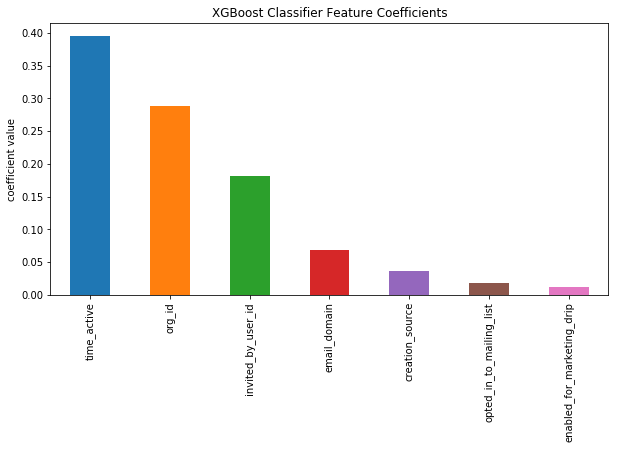

In [18]:
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('XGBoost Classifier Feature Coefficients')
plt.ylabel('coefficient value')
plt.show()

According to the feature coefficients, the time_active(differenc in time between the creation time and last login) proved to be the most important feature in determining user adoption. Second was the organization Id and third was what user they were invited by. Fourth and Fifth were email domain and creation source.